# Machine Learning Terapan Proyek Akhir
## Ahmad Zein Al Wafi
Data yang digunakan dalam proyek ini adalah data [goodbooks-10k](https://www.kaggle.com/datasets/zygmunt/goodbooks-10k) dari Kaggle Dataset. Kumpulan data ini berisi sepuluh ribu buku populer. Data ini memiliki enam file, namun pada proyek ini hanya akan menggunakan dua file dengan format csv yaitu **books** yang berisi data buku untuk membuat sistem rekomendasi berbasis content based filtering dan **ratings** yang berisi data *rating* yang diberikan oleh pengguna untuk membuat sistem rekomendasi berbasis colaborative filtering

## Persiapan Lingkungan Pengembangan

Mempersiapkan tools library yang digunakan

In [1]:
import pandas as pd
import json
import numpy as np
import time
import string
from scipy.stats import *
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import *
from keras.models import Model

Membuat file JSON untuk koneksi API ke website Kaggle

In [2]:
api = {"username":"-","key":"-"}
  
json_object = json.dumps(api, indent = 2)
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)

Instalasi agar terhubung dengan website Kaggle untuk mendapatkan data

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mendapatkan data dari Kaggle dan proses unzip data

In [4]:
! kaggle datasets download -d 'zygmunt/goodbooks-10k'
! unzip 'goodbooks-10k.zip'

 43% 5.00M/11.6M [00:00<00:00, 40.7MB/s]
100% 11.6M/11.6M [00:00<00:00, 59.4MB/s]
Archive:  goodbooks-10k.zip
  inflating: book_tags.csv           
  inflating: books.csv               
  inflating: ratings.csv             
  inflating: sample_book.xml         
  inflating: tags.csv                
  inflating: to_read.csv             


## Data Understanding

Membaca data csv books

In [5]:
books = pd.read_csv('books.csv', low_memory=False)

Melihat informasi data books

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

Melihat sample dari data

In [7]:
pd.set_option('display.max_columns', None)
books.sample(10)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3873,3874,30228,30228,2722196,28,515140872,9.780515e+12,Laurell K. Hamilton,2006.0,"Micah (Anita Blake, Vampire Hunter, #13)","Micah (Anita Blake, Vampire Hunter, #13)",en-US,3.62,37410,38534,842,2323,4989,9990,9063,12169,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
2460,2461,604803,604803,1025414,45,765315238,9.780765e+12,Terry Goodkind,2007.0,"Confessor (Sword of Truth, #11)","Confessor (Sword of Truth, #11)",en-US,4.08,37862,40294,845,1115,2265,6850,12256,17808,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
673,674,7494,7494,141228,79,446611085,9.780447e+12,James Patterson,2001.0,Suzanne's Diary for Nicholas,Suzanne's Diary for Nicholas,eng,4.16,121398,124164,4255,2106,5364,21005,38213,57476,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
4133,4134,78131,78131,75453,39,553581554,9.780554e+12,Iris Johansen,1999.0,The Killing Game,"The Killing Game (Eve Duncan, #2)",eng,4.18,24790,25473,408,126,541,4577,9698,10531,https://images.gr-assets.com/books/1314902885m...,https://images.gr-assets.com/books/1314902885s...
9597,9598,6448482,6448482,6638574,12,759530483,9.780760e+12,Atsushi Ohkubo,2004.0,ソウルイーター 2,"Soul Eater, Vol. 02 (Soul Eater, #2)",eng,4.47,9443,9540,76,51,200,1048,2180,6061,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
5494,5495,10669,10669,13308,17,375758259,9.780376e+12,Roger Lowenstein,2000.0,When Genius Failed: The Rise and Fall of Long-...,When Genius Failed: The Rise and Fall of Long-...,en-US,4.16,15619,16476,460,183,395,2606,6635,6657,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9515,9516,7199,7199,2547473,40,60586370,9.780061e+12,Ann-Marie MacDonald,2003.0,The Way the Crow Flies,The Way the Crow Flies,en-US,4.08,10227,11055,1021,184,474,1875,4317,4205,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7235,7236,7926,7926,361114,31,385732953,9.780386e+12,Sydney Taylor,1951.0,All-of-a-Kind Family,"All-of-a-Kind Family (All-of-a-Kind Family, #1)",eng,4.23,18383,19119,759,337,558,2869,6002,9353,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9736,9737,73051,73051,1181789,16,451452313,9.780451e+12,Grant Naylor,1990.0,Better Than Life,Better than Life (Red Dwarf #2),eng,4.05,9213,10069,135,59,344,2216,3881,3569,https://images.gr-assets.com/books/1301794541m...,https://images.gr-assets.com/books/1301794541s...
4469,4470,13450339,20759393,18972016,24,1442436646,9.781442e+12,Kresley Cole,2012.0,Poison Princess,"Poison Princess (The Arcana Chronicles, #1)",en-US,4.14,25679,31742,3753,1047,1457,4478,9652,15108,https://images.gr-assets.com/books/1356422925m...,https://images.gr-assets.com/books/1356422925s...


Melihat statistik deskriptif data angka non-identitas

In [8]:
books[['average_rating', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'original_publication_year', 'ratings_count', 'work_text_reviews_count']].describe()

,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,original_publication_year,ratings_count,work_text_reviews_count
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,9979.000000,1.000000e+04,10000.000000
mean,4.002191,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04,1981.987674,5.400124e+04,2919.955300
std,0.254427,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04,152.576665,1.573700e+05,6124.378132
min,2.470000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02,-1750.000000,2.716000e+03,3.000000
25%,3.850000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03,1990.000000,1.356875e+04,694.000000
50%,4.020000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03,2004.000000,2.115550e+04,1402.000000
75%,4.180000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04,2011.000000,4.105350e+04,2744.250000
max,4.820000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06,2017.000000,4.780653e+06,155254.000000


Melihat data null pada data books

In [9]:
books.isnull().sum()

id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Melihat distribusi data null

Text(0.5, 1.0, 'Distribusi nilai null pada fitur')

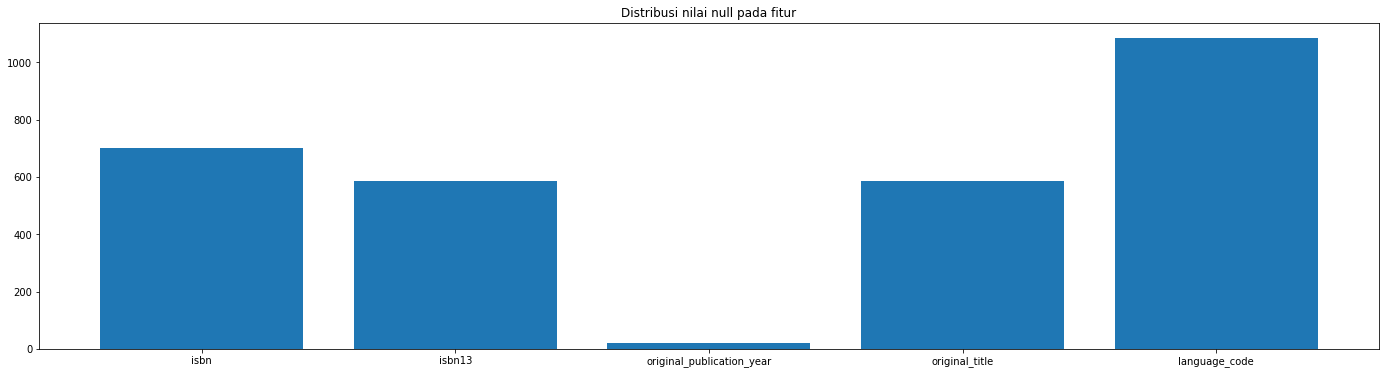

In [10]:
val_count = books[['isbn', 'isbn13', 'original_publication_year', 'original_title', 'language_code']].isnull().sum()

plt.figure(figsize=(24,6))
plt.bar(val_count.index, val_count.values)
plt.title("Distribusi nilai null pada fitur")

Melihat distribusi tahun buku, asumsinya di data ada buku yang tercipta sebelum abad 18

Text(0.5, 1.0, 'Distribusi tahun publikasi')

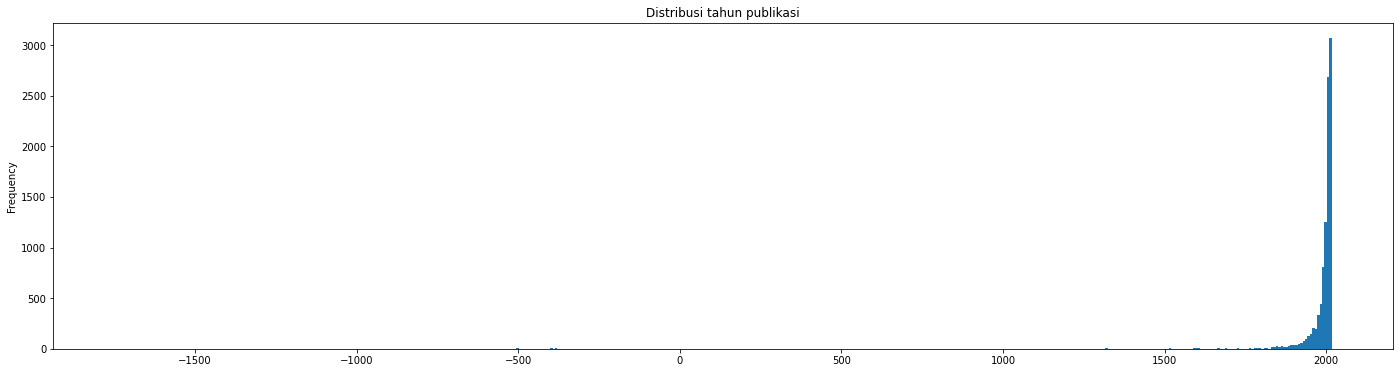

In [11]:
val_count = books['original_publication_year']

plt.figure(figsize=(24,6))
plt.hist(val_count, bins=500)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.title("Distribusi tahun publikasi")

Melihat distribusi rating, ternyata ada spike di berberapa nilai rating

Text(0.5, 1.0, 'Distribusi rata-rata rating')

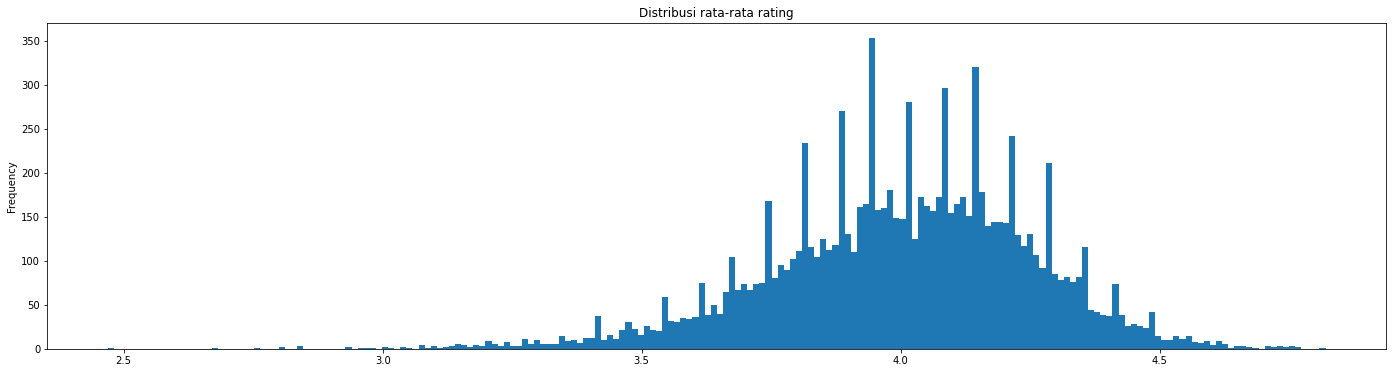

In [12]:
val_count = books['average_rating']

plt.figure(figsize=(24,6))
plt.hist(val_count, bins=200)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.title("Distribusi rata-rata rating")

Melihat distribusi secara umum dan uji normalitas

skewness: -0.5115402712762502
kurtosis: 0.8810778699146051


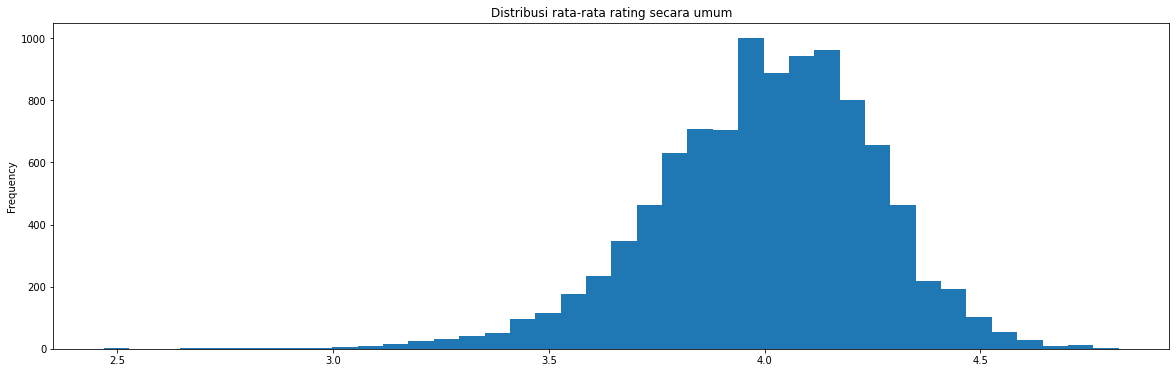

In [31]:
val_count = books['average_rating']

plt.figure(figsize=(20,6))
plt.hist(val_count, bins=40)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.title("Distribusi rata-rata rating secara umum")
print("skewness:", skew(books['average_rating'], axis=0, bias=True))
print("kurtosis:", kurtosis(books['average_rating'], axis=0, bias=True))

Melihat distribusi bahasa

Text(0.5, 1.0, 'Distribusi kode bahasa')

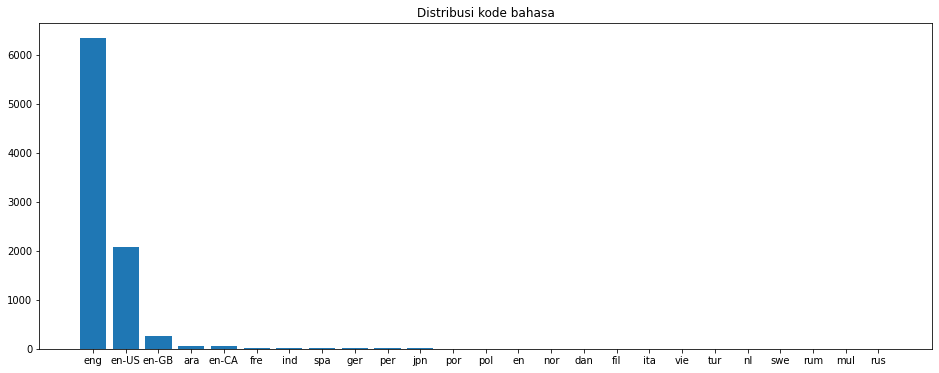

In [14]:
val_count = books['language_code'].value_counts()

plt.figure(figsize=(16,6))
plt.bar(val_count.index, val_count.values)
plt.title("Distribusi kode bahasa")

Melihat korelasi tiap kolom data

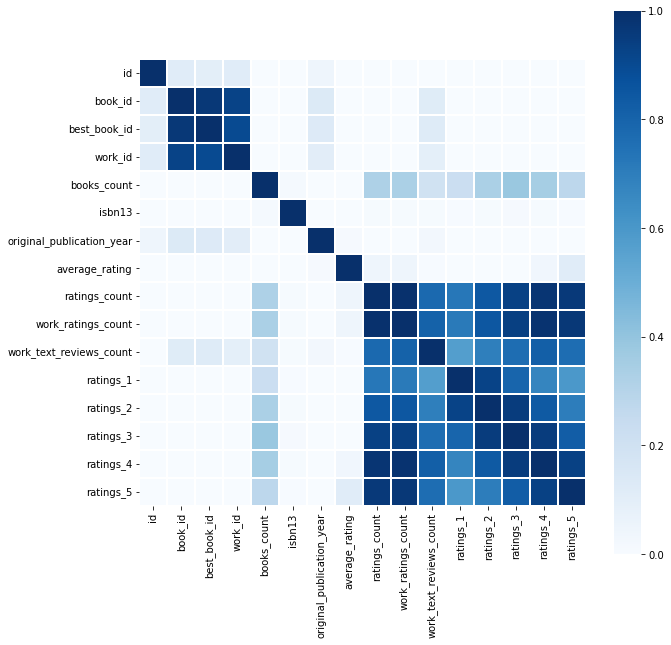

In [15]:
corr = books.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax1 = sns.heatmap(corr, cbar=1, linewidths=1,vmax=1, vmin=0, square=True, cmap='Blues', ax=ax)
plt.show()

## Data Preparation

### Content Based Filtering

Membuat dataframe sendiri untuk dimanipulasi sebagai data konten

In [16]:
combined_data = books[['original_title','authors','average_rating', 'language_code']]
combined_data = combined_data.astype(str)
combined_data['content'] = combined_data['original_title'] + ' ' + combined_data['authors'] + ' ' + combined_data['average_rating'] + ' ' + combined_data['language_code']

Memperbaharui index

In [17]:
try:
  combined_data = combined_data.reset_index()
  indices = pd.Series(combined_data.index, index=combined_data['original_title'])
except:
  pass
combined_data.sample(5)

,index,original_title,authors,average_rating,language_code,content
1075,1075,The Nest,Cynthia D'Aprix Sweeney,3.45,eng,The Nest Cynthia D'Aprix Sweeney 3.45 eng
4748,4748,"D-Day June 6, 1944: The Climactic Battle of WWII",Stephen E. Ambrose,4.25,eng,"D-Day June 6, 1944: The Climactic Battle of WW..."
9331,9331,nan,Jessica Sorensen,4.15,eng,nan Jessica Sorensen 4.15 eng
7798,7798,黒執事 II [Kuroshitsuji II],"Yana Toboso, Tomo Kimura",4.48,eng,"黒執事 II [Kuroshitsuji II] Yana Toboso, Tomo Kim..."
3959,3959,Ночной дозор,"Sergei Lukyanenko, Andrew Bromfield",3.97,eng,"Ночной дозор Sergei Lukyanenko, Andrew Bromfi..."


Melakukan pembobotan dengan metode TF-IDF

In [18]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined_data['content'])

Melihat matrix shape TF-IDF

In [19]:
tfidf_matrix.shape

(10000, 14365)

### Colaborative Filtering

Membaca data rating dan menentukan jumlah embedding

In [20]:
ratings = pd.read_csv('ratings.csv', low_memory=False)
len_user = len(ratings['user_id'].unique())
len_book = len(ratings['book_id'].unique())

Membagi data untuk pelatihan

In [21]:
train, test = train_test_split(ratings, test_size=0.3, random_state=42)

## Modelling

### Content Based Filtering

Membuat fungsi untuk rekomendasi berbasis metode Content Based Filtering

In [22]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

def showIndex(id):
  print('title:', list(combined_data.iloc[id])[1], '| author:', list(combined_data.iloc[id])[2], '| rating:', list(combined_data.iloc[id])[3])

def searchTitle(title, data):
  return list(books.loc[books['original_title'] == title][data])

def printDetails(title):
  print('\033[1m' + 'Content Details' +'\033[0m')
  print('title:', searchTitle(title, 'title')[0], '| authors:', searchTitle(title, 'authors')[0], '| rating:', searchTitle(title, 'average_rating')[0])
  return True

def recomendationContent(title, max=10):
    start_time = time.time()
    idx = indices[title]
    if(printDetails(title)):
      status = True
      sim_scores = list(enumerate(cosine_sim[idx]))
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      book_indices = [i[0] for i in sim_scores[:max+1]]
      print('\033[1m'+f'\nTop {max} Recomendation - Content Based Filtering'+'\033[0m')
      for i in range(len(book_indices)-1):
        showIndex(book_indices[i+1]) if status else showIndex(book_indices[i])
    else:
      print('Content is not in database, therefore this system recomendation will be offline')
      print("\nRecomendation system run time is %s seconds" % (time.time() - start_time))

Memberikan rekomendasi dengan content based filtering

In [23]:
recomendationContent('The Hunger Games')

Content Details
title: The Hunger Games (The Hunger Games, #1) | authors: Suzanne Collins | rating: 4.34

Top 10 Recomendation - Content Based Filtering
title: The Hunger Games Box Set | author: Suzanne Collins | rating: 4.49
title: Catching Fire | author: Suzanne Collins | rating: 4.3
title: Mockingjay | author: Suzanne Collins | rating: 4.03
title: Gregor the Overlander | author: Suzanne Collins | rating: 3.99
title: Gregor and the Curse of the Warmbloods | author: Suzanne Collins | rating: 4.2
title: Gregor and the Marks of Secret | author: Suzanne Collins | rating: 4.21
title: Gregor and the Prophecy of Bane | author: Suzanne Collins | rating: 4.17
title: Gregor and the Code of Claw | author: Suzanne Collins | rating: 4.25
title: Hunger  | author: Michael  Grant | rating: 4.02
title: A Hunger Like No Other | author: Kresley Cole | rating: 4.21


### Colaborative Filtering

Pembuatan arsitektur jaringan syaraf tiruan dengan KERAS API

In [24]:
books_input = Input(shape=[1], name="Books-Input")
books_embedding = Embedding(len_user+1, 4, name="Books-Embedding")(books_input)
books_vec = Flatten(name="Flatten-Books")(books_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(len_user+1, 4, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

conc_2veclayer = Concatenate()([books_vec, user_vec])

fc1 = Dense(256, activation='relu')(conc_2veclayer)
fc2 = Dense(128, activation='relu')(fc1)
out = Dense(1)(fc2)

model = Model([user_input, books_input], out)
model.compile('adam', 'mean_squared_error')

Melihat rangkuman arsitektur

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Books-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Books-Embedding (Embedding)    (None, 1, 4)         213700      ['Books-Input[0][0]']            
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 4)         213700      ['User-Input[0][0]']             
                                                                                              

Melihat visualisasi arsitektur

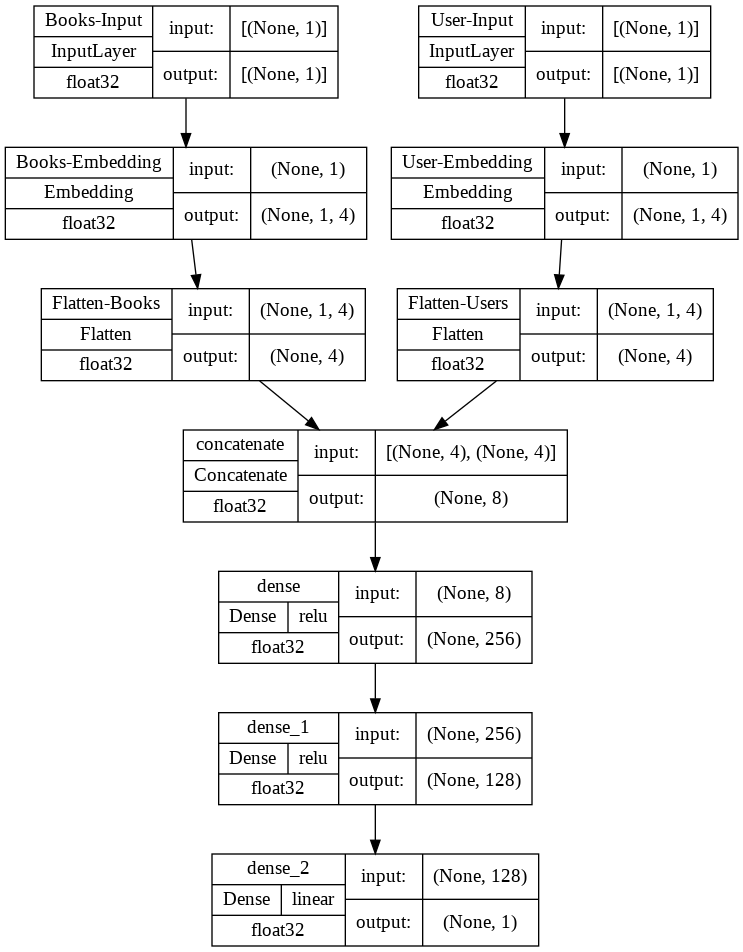

In [26]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

Melatih model

In [27]:
epoch = 16
batch_size = 64
history = model.fit(
    [train.user_id, train.book_id], 
    train.rating, 
    batch_size=batch_size,
    epochs=epoch, 
    verbose=1)

Epoch 1/16
10738/10738 [==============================] - 100s 9ms/step - loss: 0.8177
Epoch 2/16
10738/10738 [==============================] - 105s 10ms/step - loss: 0.6865
Epoch 3/16
10738/10738 [==============================] - 131s 12ms/step - loss: 0.6611
Epoch 4/16
10738/10738 [==============================] - 112s 10ms/step - loss: 0.6364
Epoch 5/16
10738/10738 [==============================] - 107s 10ms/step - loss: 0.6137
Epoch 6/16
10738/10738 [==============================] - 95s 9ms/step - loss: 0.5936
Epoch 7/16
10738/10738 [==============================] - 97s 9ms/step - loss: 0.5756
Epoch 8/16
10738/10738 [==============================] - 97s 9ms/step - loss: 0.5589
Epoch 9/16
10738/10738 [==============================] - 95s 9ms/step - loss: 0.5429
Epoch 10/16
10738/10738 [==============================] - 96s 9ms/step - loss: 0.5289
Epoch 11/16
10738/10738 [==============================] - 97s 9ms/step - loss: 0.5166
Epoch 12/16
10738/10738 [==================

Melihat visualisasi riwayat pelatihan

dict_keys(['loss'])


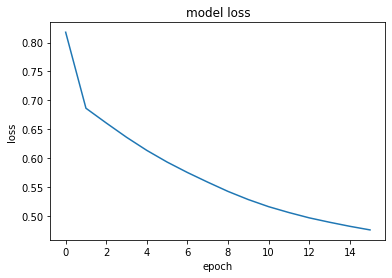

In [28]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Membuat fungsi untuk menampilkan hasil rekomendasi

In [29]:
book = pd.read_csv('books.csv', low_memory=False)
def searchId(id, data):
  return book.loc[book['id'] == id][data].values[0]
def showId(id):
  print('title:', searchId(id,'original_title'), '| author:', searchId(id,'authors'), '| rating:', searchId(id,'average_rating'))

def recomendationColaborative(id_user, max=10, booksReaded=False):
  start_time = time.time()
  books_rating = np.array(list(set(ratings.book_id)))
  book = pd.read_csv('books.csv', low_memory=False)
  user_readed = (ratings.loc[ratings['user_id'] == id_user])['book_id'].values
  if booksReaded == True:
    for i in user_readed:
      showId(i)
  user = np.array([id_user for i in range(len(books_rating))])
  predictions = model.predict([user, books_rating])
  predictions = np.array([a[0] for a in predictions])
  top10 = (-predictions).argsort()[:max]
  print('\033[1m'+f'\nTop {max} Recomendation - Collaborative Filtering'+'\033[0m')
  for i in top10:
    showId(i)
  print("\nRecomendation system runtime is %s seconds" % (time.time() - start_time))

Memberikan rekomendasi dengan metode colaborative filtering

In [35]:
recomendationColaborative(911)

313/313 [==============================] - 1s 2ms/step

Top 10 Recomendation - Collaborative Filtering
title: The Source of Magic (Xanth, #2) | author: Piers Anthony | rating: 3.86
title: Love Story | author: Erich Segal | rating: 3.6
title: Hothouse Flower | author: Lucinda Riley | rating: 3.8
title: The Night is for Hunting | author: John Marsden | rating: 4.15
title: The First Confessor | author: Terry Goodkind | rating: 4.19
title: Pinkalicious | author: Victoria Kann, Elizabeth Kann | rating: 4.05
title: Identical | author: Ellen Hopkins | rating: 4.34
title: How Soccer Explains the World: An Unlikely Theory of Globalization | author: Franklin Foer | rating: 3.76
title: The Next Accident | author: Lisa Gardner | rating: 4.16
title: Red | author: Ted Dekker | rating: 4.3

Recomendation system runtime is 1.5996742248535156 seconds
